# Lenia

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [1]:
import jax
import jax.numpy as jnp
import mediapy
from cax.core.ca import CA
from cax.core.perceive.lenia_perceive import LeniaPerceive
from cax.core.update.lenia_update import LeniaUpdate
from flax import nnx

## Configuration

In [ ]:
seed = 0

lenia_config = {
	"state_size": 128,
	"channel_size": 3,
	"R": 12,
	"T": 2,
	"state_scale": 1,
	"kernel_params": [
		{"b": [1], "m": 0.272, "s": 0.0595, "h": 0.138, "r": 0.91, "c0": 0, "c1": 0},
		{"b": [1], "m": 0.349, "s": 0.1585, "h": 0.48, "r": 0.62, "c0": 0, "c1": 0},
		{"b": [1, 1 / 4], "m": 0.2, "s": 0.0332, "h": 0.284, "r": 0.5, "c0": 0, "c1": 0},
		{"b": [0, 1], "m": 0.114, "s": 0.0528, "h": 0.256, "r": 0.97, "c0": 1, "c1": 1},
		{"b": [1], "m": 0.447, "s": 0.0777, "h": 0.5, "r": 0.72, "c0": 1, "c1": 1},
		{"b": [5 / 6, 1], "m": 0.247, "s": 0.0342, "h": 0.622, "r": 0.8, "c0": 1, "c1": 1},
		{"b": [1], "m": 0.21, "s": 0.0617, "h": 0.35, "r": 0.96, "c0": 2, "c1": 2},
		{"b": [1], "m": 0.462, "s": 0.1192, "h": 0.218, "r": 0.56, "c0": 2, "c1": 2},
		{"b": [1], "m": 0.446, "s": 0.1793, "h": 0.556, "r": 0.78, "c0": 2, "c1": 2},
		{"b": [11 / 12, 1], "m": 0.327, "s": 0.1408, "h": 0.344, "r": 0.79, "c0": 0, "c1": 1},
		{"b": [3 / 4, 1], "m": 0.476, "s": 0.0995, "h": 0.456, "r": 0.5, "c0": 0, "c1": 2},
		{"b": [11 / 12, 1], "m": 0.379, "s": 0.0697, "h": 0.67, "r": 0.72, "c0": 1, "c1": 0},
		{"b": [1], "m": 0.262, "s": 0.0877, "h": 0.42, "r": 0.68, "c0": 1, "c1": 2},
		{"b": [1 / 6, 1, 0], "m": 0.412, "s": 0.1101, "h": 0.43, "r": 0.82, "c0": 2, "c1": 0},
		{"b": [1], "m": 0.201, "s": 0.0786, "h": 0.278, "r": 0.82, "c0": 2, "c1": 1},
	],
}

num_steps = 128

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Init state

In [3]:
def init_state(pattern):
	pattern = jnp.transpose(pattern, axes=(1, 2, 0))

	state_size, channel_size, state_scale = (
		lenia_config["state_size"],
		lenia_config["channel_size"],
		lenia_config["state_scale"],
	)
	mid = state_size // 2

	# Scale cells
	scaled_cells = pattern.repeat(state_scale, axis=-3).repeat(state_scale, axis=-2)
	cx, cy = scaled_cells.shape[0], scaled_cells.shape[1]

	# Create empty state and place cells
	state = jnp.zeros((state_size, state_size, channel_size))
	state = state.at[mid - cx // 2 : mid + cx - cx // 2, mid - cy // 2 : mid + cy - cy // 2, :].set(scaled_cells)
	return state

In [10]:
# fmt: off
patterns = {
	"VT049W": jnp.asarray([
		[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.49, 1.0, 0, 0.03, 0.49, 0.49, 0.28, 0.16, 0.03, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6, 0.47, 0.31, 0.58, 0.51, 0.35, 0.28, 0.22, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.15, 0.32, 0.17, 0.61, 0.97, 0.29, 0.67, 0.59, 0.88, 1.0, 0.92, 0.8, 0.61, 0.42, 0.19, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.25, 0.64, 0.26, 0.92, 0.04, 0.24, 0.97, 1.0, 1.0, 1.0, 1.0, 0.97, 0.71, 0.33, 0.12, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.38, 0.84, 0.99, 0.78, 0.67, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.62, 0.37, 0, 0], [0, 0, 0, 0, 0.04, 0.11, 0, 0.69, 0.75, 0.75, 0.91, 1.0, 1.0, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.81, 0.42, 0.07, 0], [0, 0, 0, 0, 0.44, 0.63, 0.04, 0, 0, 0, 0.11, 0.14, 0, 0.05, 0.64, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92, 0.56, 0.23, 0], [0, 0, 0, 0, 0.11, 0.36, 0.35, 0.2, 0, 0, 0, 0, 0, 0, 0.63, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.49, 0.26, 0], [0, 0, 0, 0, 0, 0.4, 0.37, 0.18, 0, 0, 0, 0, 0, 0.04, 0.41, 0.52, 0.67, 0.82, 1.0, 1.0, 0.91, 0.4, 0.23, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0, 0.05, 0.45, 0.89, 1.0, 0.66, 0.35, 0.09, 0], [0, 0, 0.22, 0, 0, 0, 0.05, 0.36, 0.6, 0.13, 0.02, 0.04, 0.24, 0.34, 0.1, 0, 0.04, 0.62, 1.0, 1.0, 0.44, 0.25, 0, 0], [0, 0, 0, 0.43, 0.53, 0.58, 0.78, 0.9, 0.96, 1.0, 1.0, 1.0, 1.0, 0.71, 0.46, 0.51, 0.81, 1.0, 1.0, 0.93, 0.19, 0.06, 0, 0], [0, 0, 0, 0, 0.23, 0.26, 0.37, 0.51, 0.71, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.42, 0.06, 0, 0, 0], [0, 0, 0, 0, 0.03, 0, 0, 0.11, 0.35, 0.62, 0.81, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 0.64, 0.15, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.06, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.05, 0.09, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],  # noqa
		[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.28, 0.42, 0.44, 0.34, 0.18, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.34, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91, 0.52, 0.14, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.17, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 0.35, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.22, 0.92, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.59, 0.09], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.71, 0.16], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.67, 0.83, 0.85, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.68, 0.17], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21, 0.04, 0.12, 0.58, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.57, 0.13], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07, 0, 0, 0, 0.2, 0.64, 0.96, 1.0, 1.0, 1.0, 0.9, 0.24, 0.01], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13, 0.29, 0, 0, 0, 0.25, 0.9, 1.0, 1.0, 1.0, 1.0, 0.45, 0.05, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13, 0.31, 0.07, 0, 0.46, 0.96, 1.0, 1.0, 1.0, 1.0, 0.51, 0.12, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.26, 0.82, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.05, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.28, 0.74, 1.0, 0.95, 0.87, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.07, 0.69, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.25, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0.72, 0.9, 0.83, 0.7, 0.56, 0.43, 0.14, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],  # noqa
		[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.25, 0.37, 0.44, 0.37, 0.24, 0.11, 0.04, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.19, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.4, 0.15, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.14, 0.48, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.62, 0.78, 0.94, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.64, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.02, 0.65, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.78, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.15, 0.48, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.79, 0.05, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.33, 0.56, 0.8, 1.0, 1.0, 1.0, 0.37, 0.6, 0.94, 1.0, 1.0, 1.0, 1.0, 0.68, 0.05, 0, 0, 0], [0, 0, 0, 0, 0.35, 0.51, 0.76, 0.89, 1.0, 1.0, 0.72, 0.15, 0, 0.29, 0.57, 0.69, 0.86, 1.0, 0.92, 0.49, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.38, 0.86, 1.0, 1.0, 0.96, 0.31, 0, 0, 0, 0, 0.02, 0.2, 0.52, 0.37, 0.11, 0, 0, 0, 0], [0, 0, 0.01, 0, 0, 0.07, 0.75, 1.0, 1.0, 1.0, 0.48, 0.03, 0, 0, 0, 0, 0, 0.18, 0.07, 0, 0, 0, 0, 0], [0, 0.11, 0.09, 0.22, 0.15, 0.32, 0.71, 0.94, 1.0, 1.0, 0.97, 0.54, 0.12, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.06, 0.33, 0.47, 0.51, 0.58, 0.77, 0.95, 1.0, 1.0, 1.0, 1.0, 0.62, 0.12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.04, 0.4, 0.69, 0.88, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 0.68, 0.22, 0.02, 0, 0, 0.01, 0, 0, 0, 0, 0, 0, 0], [0, 0.39, 0.69, 0.91, 1.0, 1.0, 1.0, 1.0, 1.0, 0.85, 0.52, 0.35, 0.24, 0.17, 0.07, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.29, 0.82, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.67, 0.29, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.2, 0.51, 0.77, 0.96, 0.93, 0.71, 0.4, 0.16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.08, 0.07, 0.03, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],  # noqa
	]),
	"5N7KKM": jnp.asarray([
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.12, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.49, 0, 0, 0, 0, 0, 0, 0.23, 0.47, 0.31, 0.93, 0.75, 0, 0, 0, 0], [0, 0, 0, 0.23, 0, 0, 0.65, 0.68, 0.12, 0, 0, 0, 0.02, 0.40, 0.82, 0.86, 0, 0.19, 0, 0], [0, 0, 0.01, 0.01, 0.77, 1.00, 0.98, 1.00, 0.97, 0.85, 0.70, 0.55, 0.12, 0.15, 0.01, 0, 0, 0.95, 0, 0], [0, 0, 0, 0.66, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.74, 0.76, 0.27, 0, 0, 0.18, 0.59, 0.31, 0], [0, 0.04, 0.08, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.88, 0.68, 0.07, 0, 0, 0, 0, 0, 0], [0, 0, 0.29, 1.00, 1.00, 1.00, 1.00, 0.90, 1.00, 0.92, 0.58, 0.84, 0.89, 0.39, 0, 0, 0.04, 1.00, 0, 0], [0, 0.06, 0.27, 1.00, 1.00, 1.00, 0.82, 0.39, 0, 0, 0, 0.12, 0.87, 0.70, 0.58, 0.04, 0.40, 1.00, 0.35, 0], [0, 0.21, 0.38, 1.00, 1.00, 0.66, 0, 0, 0, 0, 0, 0, 1.00, 0.79, 0.74, 0.16, 0.31, 0.42, 0, 0], [0, 0.26, 0.50, 1.00, 1.00, 0.46, 0, 0, 0, 0, 0, 0.40, 1.00, 1.00, 0.71, 0.16, 0, 0.22, 0, 0], [0, 0.14, 0.48, 1.00, 1.00, 0.77, 0, 0, 0, 0, 0, 1.00, 1.00, 1.00, 0.79, 0, 0, 0, 0, 0], [0, 0, 0.16, 1.00, 1.00, 1.00, 0.19, 0, 0, 0.09, 0.20, 0.57, 1.00, 1.00, 0.74, 0, 0, 0, 0, 0], [0, 0, 0, 0.59, 1.00, 1.00, 0.85, 0.75, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.47, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.95, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.96, 0.44, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.25, 0.79, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.96, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.04, 0.06, 0.26, 0.61, 1.00, 1.00, 1.00, 1.00, 1.00, 0, 0, 0.32, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.15, 0, 0.02, 0.23, 0.24, 0.05, 0, 0, 0.25, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.04, 0, 0, 0.08, 0, 0, 0, 0, 0, 0, 0]],  # noqa
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.03, 0.43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.14, 0.47, 0, 0, 0.27, 0.92, 0.87, 0.70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.86, 1.00, 0.66, 1.00, 1.00, 1.00, 1.00, 0.33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 0.13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 0, 0.22, 0.30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.76, 1.00, 1.00, 1.00, 1.00, 1.00, 0.83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.71, 1.00, 1.00, 1.00, 1.00, 0.77, 0.81, 0.75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.69, 1.00, 1.00, 1.00, 0.88, 0.24, 0.35, 0.62, 0.35, 0.09, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.29, 1.00, 1.00, 1.00, 0.98, 0.38, 0.13, 0.65, 0.88, 0.32, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.09, 1.00, 1.00, 1.00, 0.93, 0.77, 0.88, 0.24, 0.03, 0.69, 1.00, 0.78, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.44, 1.00, 1.00, 1.00, 1.00, 1.00, 0.76, 0.83, 1.00, 0.92, 0.17, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.36, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.12, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.06, 0.39, 0.79, 1.00, 1.00, 1.00, 0.48, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.16, 0.59, 1.00, 1.00, 1.00, 0.13, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.16, 0.02, 0, 0, 0, 0, 0, 0, 0, 0]],  # noqa
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.51, 0.46, 0.26, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.38, 1.00, 1.00, 0.96, 0.85, 0.57, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.06, 0.63, 1.00, 1.00, 1.00, 1.00, 0.96, 0.70, 0.08, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.01, 0.36, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.82, 0.49, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.05, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.99, 0.65, 0.04, 0, 0, 0, 0], [0, 0, 0.01, 0, 0.08, 0.52, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.93, 0, 0, 0, 0, 0], [0, 0, 0.03, 0, 0.09, 0.49, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.58, 0.04, 0, 0, 0, 0, 0], [0, 0, 0.02, 0, 0.08, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 0.81, 0, 0, 0, 0, 0.08, 0.01, 0, 0], [0, 0, 0, 0, 0.04, 0.47, 1.00, 1.00, 1.00, 1.00, 0.40, 0, 0, 0, 0, 0.77, 0.85, 0.35, 0, 0], [0, 0, 0, 0, 0.03, 0.41, 1.00, 1.00, 1.00, 1.00, 0.20, 0, 0, 0.01, 1.00, 1.00, 1.00, 0.55, 0, 0], [0, 0, 0, 0, 0, 0.30, 0.98, 1.00, 1.00, 1.00, 0.68, 0.09, 0.26, 1.00, 1.00, 1.00, 1.00, 0.70, 0.19, 0], [0, 0, 0, 0, 0, 0.13, 0.55, 0.95, 1.00, 1.00, 1.00, 0.89, 1.00, 1.00, 1.00, 1.00, 1.00, 0.85, 0.67, 0.24], [0, 0, 0, 0, 0, 0.02, 0.31, 0.63, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.88, 0.45], [0, 0, 0, 0, 0, 0, 0.12, 0.44, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.91, 0.36], [0, 0, 0, 0, 0, 0, 0, 0.16, 0.48, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.86, 0.06], [0, 0, 0, 0, 0, 0, 0, 0, 0.13, 0.32, 0.70, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.28, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06, 0.18, 0.32, 0.57, 0.90, 1.00, 1.00, 1.00, 0.08, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.12, 0.25, 0.39, 0.31, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0]],  # noqa
	]),
}

## Model

In [11]:
perceive = LeniaPerceive(lenia_config)
update = LeniaUpdate(lenia_config)
ca = CA(perceive, update)

## Visualize

In [12]:
state = init_state(patterns["VT049W"])
state = ca(state, num_steps=128, all_steps=True)

""

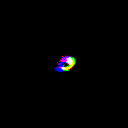

In [13]:
mediapy.show_video(state, width=256, height=256, codec="gif")

In [14]:
state = init_state(patterns["5N7KKM"])
state = ca(state, num_steps=128, all_steps=True)

""

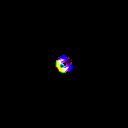

In [15]:
mediapy.show_video(state, width=256, height=256, codec="gif")